# PCA, NMDS and heatmap analysis of shotgun metagenomics data 

The analyses presented here is for the shotgun metagenomics data. The shotgun data was analyzed by metaphlan first. I have upload a R script to show how to run metaphlan using R and the advantage of doing in R is able to loop through the samples instead of running the analysis one by one. 

The workflow for this analysis is 
(1) install and updload the libraries, 
(2) wrangle dataset for analysis and select Class data for analysis
(3) Perform NMDS, PCA and heatmap analysis 

In [7]:
#install packages
install.packages(c("splitstackshape", "reshape2", "ecodist", "devtools", "ggbiplot", "vegan", "plyr", "pheatmap"))
install_github("vqv/ggbiplot")

Warning message:
“package ‘ggbiplot’ is not available (for R version 3.3.2)”also installing the dependencies ‘memoise’, ‘whisker’, ‘rstudioapi’, ‘git2r’, ‘withr’, ‘permute’



In [4]:
#load packages
x = c("splitstackshape", "reshape2", "ecodist", "devtools", "ggbiplot", "vegan", "ggplot2", "dplyr", "plyr", "pheatmap")
lapply(x, require, character.only = TRUE)

Loading required package: splitstackshape
Loading required package: data.table
Loading required package: reshape2

Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt

Loading required package: ecodist
Loading required package: devtools
Loading required package: ggbiplot
Loading required package: ggplot2
Loading required package: plyr
Loading required package: scales
Loading required package: grid
Loading required package: vegan
Loading required package: permute

Attaching package: ‘permute’

The following object is masked from ‘package:devtools’:

    check

Loading required package: lattice
This is vegan 2.4-3

Attaching package: ‘vegan’

The following object is masked from ‘package:ecodist’:

    mantel

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are mas

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

In [42]:
#Explore the data 
raw_abundance <- read.csv("~/RCode/raw_water_metaphlan_abundance.csv", header=TRUE)
data <- raw_abundance
head(data, 30)

ID,RE_4_Peak_Composite,RE_7_Peak_Composite,RE_9_Peak_Composite,RE_10_Peak_Composite,RE_14_Peak_Composite,RE_15_Peak_Composite,RE_7_Fall_Composite,RE_12_Rise_Composite,RE_12_Fall_Composite,RE_8_Rise_Composite,RE_8_Fall_Composite,RE_9_Rise_Composite,RE_9_Fall_Composite,RE_10_Rise_Composite
k__Archaea,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Archaea|p__Euryarchaeota,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Archaea|p__Euryarchaeota|c__Methanobacteria,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_unclassified,0.00000,0.00000,0.00000,0.44066,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000
k__Bacteria,100.00000,100.00000,97.47484,99.55934,100.00000,100.00000,100.00000,100.00000,100.0000,100.00000,100.00000,100.00000,100.00000,100.00000
k__Bacteria|p__Acidobacteria,0.00000,0.00000,0.00000,0.95539,0.00000,0.92161,0.00000,1.06100,0.0000,1.76465,0.00000,0.00000,0.00000,5.03604
k__Bacteria|p__Acidobacteria|c__Acidobacteriia,0.00000,0.00000,0.00000,0.95539,0.00000,0.92161,0.00000,1.06100,0.0000,1.76465,0.00000,0.00000,0.00000,5.03604


In [52]:
#wrangling dataset for analysis and select Class data for analysis
dt <- cSplit(data, 'ID', '|')
dt <- plyr::rename(dt, c("ID_1"="Kingdom", "ID_2"="Phylum", "ID_3"="Class", "ID_4"="Order","ID_5"="Family",
                             "ID_6"="Genius", "ID_7"="Species", "ID_8"="Strain"))
dt <- dt %>% select(Kingdom:Strain, everything())
class_dt <- dt %>% filter(Class != "NA") 
class_dt <- class_dt[is.na(class_dt$Order),]
class_dt <- select(class_dt, Class, RE_4_Peak_Composite:RE_10_Rise_Composite)
class_dt <- as.data.frame(t(class_dt), stringsAsFactors = FALSE)
colnames(class_dt) <- class_dt[1,]  # the first row will be the header
class_dt <- class_dt[-1, ]
class_dt$Sample_ID <- rownames(class_dt)
class_dt[,1:10] <- apply(class_dt[,1:10], 2, FUN = as.numeric)

#sorting the sample into rain and baseflow event
class_dt$Rain <- ifelse(grepl("Peak", class_dt$Sample_ID, ignore.case = T), "Peak", 
                          ifelse(grepl("Fall", class_dt$Sample_ID, ignore.case = T), "Fall", 
                                 ifelse(grepl("Rise", class_dt$Sample_ID, ignore.case = T), "Rise", "Others")))
colnames(class_dt) <- gsub("c__", "", colnames(class_dt))
rownames(class_dt) <- gsub("_Composite", "", rownames(class_dt))
class_dt <- class_dt[ ,-which(names(class_dt) == "Sample_ID")]

#prepare data for heatmap analysis 
class.dt.heat <- class_dt[,1:10]
class.dt.heat <- data.matrix(class.dt.heat)/100 #convert abundance to percentage

head(class_dt)

,Methanobacteria,Acidobacteriia,Actinobacteria,Sphingobacteriia,Cyanobacteria_noname,Clostridia,Alphaproteobacteria,Betaproteobacteria,Gammaproteobacteria,Eurotiomycetes,Rain
RE_4_Peak,0.00000,0.00000,13.85926,20.63092,0.00000,0.00000,0.00000,26.45175,39.05807,0.00000,Peak
RE_7_Peak,0.00000,0.00000,10.24651,4.02349,0.00000,0.00000,14.40466,23.59689,47.72845,0.00000,Peak
RE_9_Peak,0.00000,0.00000,44.22903,0.00000,0.80588,0.00000,5.31581,17.91369,29.21043,2.52516,Peak
RE_10_Peak,0.44066,0.95539,7.77521,7.44123,11.42581,2.74255,8.40348,29.39324,31.42244,0.00000,Peak
RE_14_Peak,0.00000,0.00000,15.43401,0.00000,11.83405,0.00000,2.37965,21.10430,49.24798,0.00000,Peak
RE_15_Peak,0.00000,0.92161,16.30771,0.00000,0.81621,0.00000,3.42823,59.79055,18.73569,0.00000,Peak


Square root transformation
Wisconsin double standardization
Run 0 stress 0.1637711 
Run 1 stress 0.233746 
Run 2 stress 0.2010169 
Run 3 stress 0.165652 
Run 4 stress 0.1722 
Run 5 stress 0.1783714 
Run 6 stress 0.1783683 
Run 7 stress 0.1637711 
... New best solution
... Procrustes: rmse 9.124383e-05  max resid 0.0001733608 
... Similar to previous best
Run 8 stress 0.1800402 
Run 9 stress 0.1783694 
Run 10 stress 0.2497944 
Run 11 stress 0.163771 
... New best solution
... Procrustes: rmse 0.0001711715  max resid 0.0002836947 
... Similar to previous best
Run 12 stress 0.1627031 
... New best solution
... Procrustes: rmse 0.1043718  max resid 0.2849749 
Run 13 stress 0.2297215 
Run 14 stress 0.213234 
Run 15 stress 0.2567023 
Run 16 stress 0.1627027 
... New best solution
... Procrustes: rmse 0.0004347102  max resid 0.001001494 
... Similar to previous best
Run 17 stress 0.1637712 
Run 18 stress 0.1642092 
Run 19 stress 0.2160742 
Run 20 stress 0.163771 
*** Solution reached


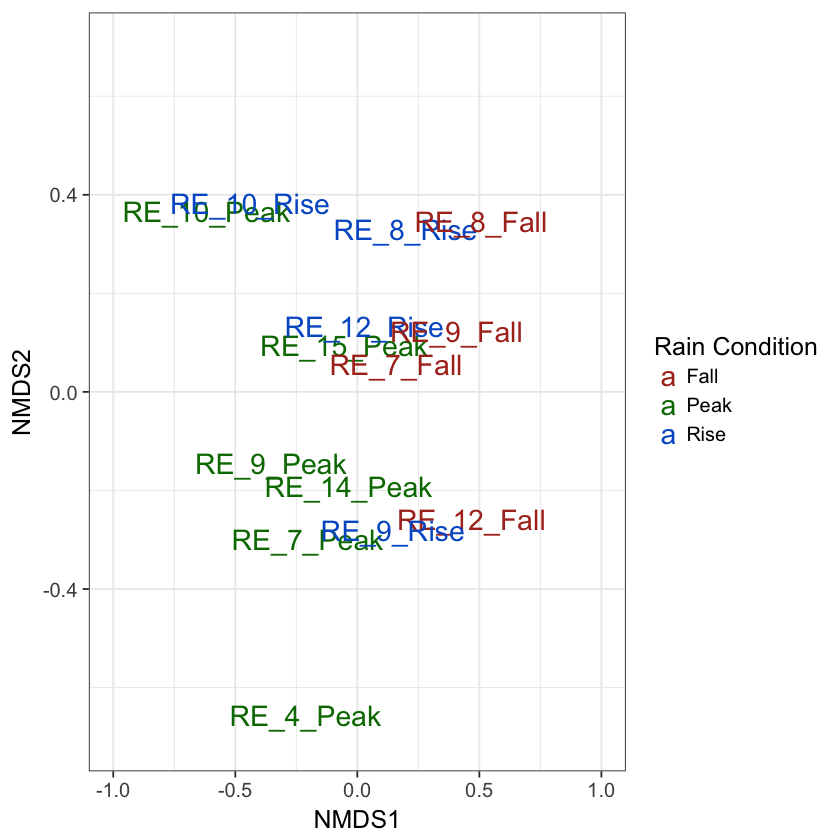

In [56]:
#nmds
class.mds <- metaMDS(class_dt[,1:10]) 
data.scores <- as.data.frame(scores(class.mds))  #Using the scores function from vegan to extract the site scores and convert to a data.frame
data.scores$Rain <- class_dt$Rain

#nmds_ggplot
ggplot(data.scores, aes(x=NMDS1,y=NMDS2, color = factor(Rain),label=rownames(data.scores))) + 
  geom_text(aes(colour = factor(Rain)), size=6) +
  scale_colour_discrete(name = "Rain Condition",l = 40) +
  ylim(-0.70,0.70) +
  xlim(-1.0,1.0) +
  theme(axis.text=element_text(size=11, color ="black"),
        axis.title.y=element_text(size=14,face="bold", vjust=1), 
        axis.title.x=element_text(size=14,face="bold", vjust=-0.1)) +
  theme_bw(base_size = 15) 

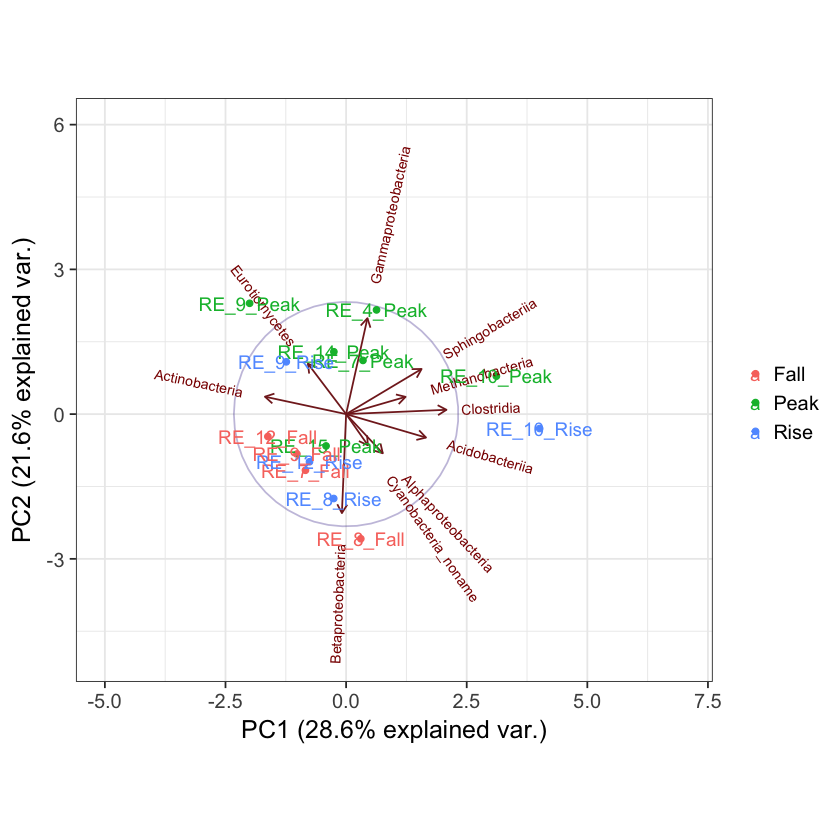

In [60]:
#PCA analysis and PCA plot 
class.pca <- prcomp(class_dt[,1:10],
                    center = TRUE,
                    scale. = TRUE) 


ggbiplot(class.pca, obs.scale = 1, var.scale = 1, groups = class_dt$Rain, ellipse = FALSE, 
         circle = TRUE, varname.size = 3) + 
  scale_color_discrete(name = "") + 
  theme(legend.direction = 'horizontal', legend.position = 'top') +
  geom_text(aes(label=rownames(class_dt), colour = factor(class_dt$Rain)),size=4) +
  ylim(-5,6) +
  xlim(-5,7) +
  theme(axis.text=element_text(size=11, color ="black"),
        axis.title.y=element_text(size=14,face="bold", vjust=1), 
        axis.title.x=element_text(size=14,face="bold", vjust=1)) +
  theme_bw(base_size = 15) 

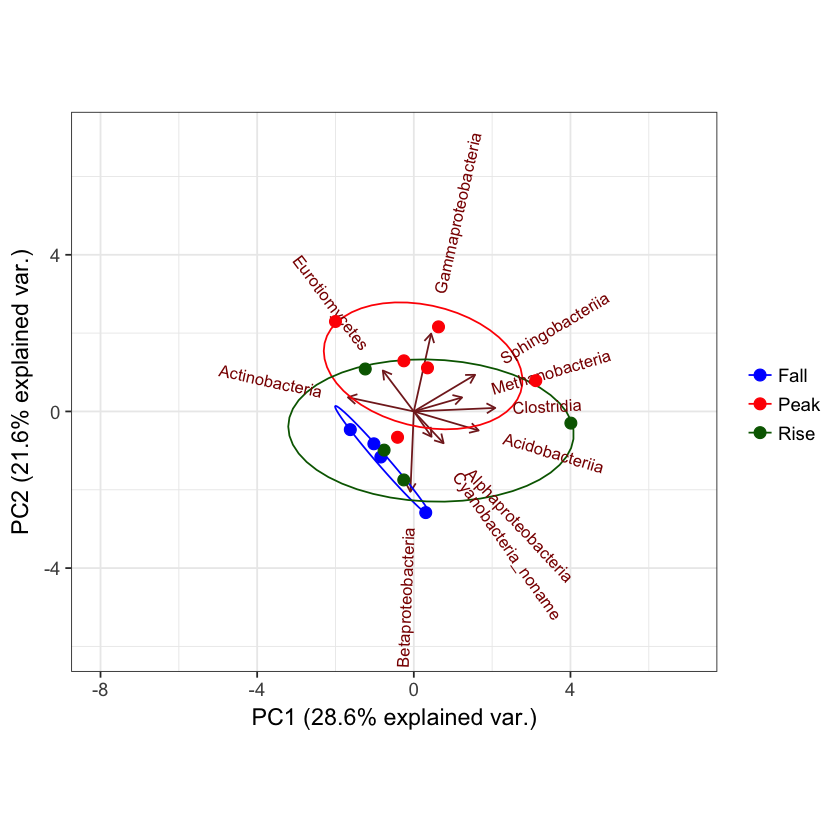

In [59]:
#Modify PCA plot to separate Baseflow and Rain Event on the plot

ggbiplot(class.pca, obs.scale = 1, var.scale = 1, groups = class_dt$Rain, ellipse = TRUE, 
         circle = FALSE, varname.size = 3.5, varname.col = "black", labels.size = 10, labels.col="black") + 
  geom_point(aes(color=factor(class_dt$Rain)), size=3) +
  scale_color_manual(values=c("blue", "red", "dark green"), name="") +
  theme(legend.direction = 'horizontal', legend.position = 'top') +
  ylim(-6,7) +
  xlim(-8,7) +
  theme(axis.text=element_text(size=10, color ="black"),
        axis.title.y=element_text(size=10,face="bold", vjust=1), 
        axis.title.x=element_text(size=10,face="bold", vjust=-0.1)) +
  theme_bw(base_size = 14)

In [62]:
head(class.data.heat)

,Methanobacteria,Acidobacteriia,Actinobacteria,Sphingobacteriia,Cyanobacteria_noname,Clostridia,Alphaproteobacteria,Betaproteobacteria,Gammaproteobacteria,Eurotiomycetes
RE_4_Peak,0.0000000,0.0000000,0.1385926,0.2063092,0.0000000,0.0000000,0.0000000,0.2645175,0.3905807,0.0000000
RE_7_Peak,0.0000000,0.0000000,0.1024651,0.0402349,0.0000000,0.0000000,0.1440466,0.2359689,0.4772845,0.0000000
RE_9_Peak,0.0000000,0.0000000,0.4422903,0.0000000,0.0080588,0.0000000,0.0531581,0.1791369,0.2921043,0.0252516
RE_10_Peak,0.0044066,0.0095539,0.0777521,0.0744123,0.1142581,0.0274255,0.0840348,0.2939324,0.3142244,0.0000000
RE_14_Peak,0.0000000,0.0000000,0.1543401,0.0000000,0.1183405,0.0000000,0.0237965,0.2110430,0.4924798,0.0000000
RE_15_Peak,0.0000000,0.0092161,0.1630771,0.0000000,0.0081621,0.0000000,0.0342823,0.5979055,0.1873569,0.0000000


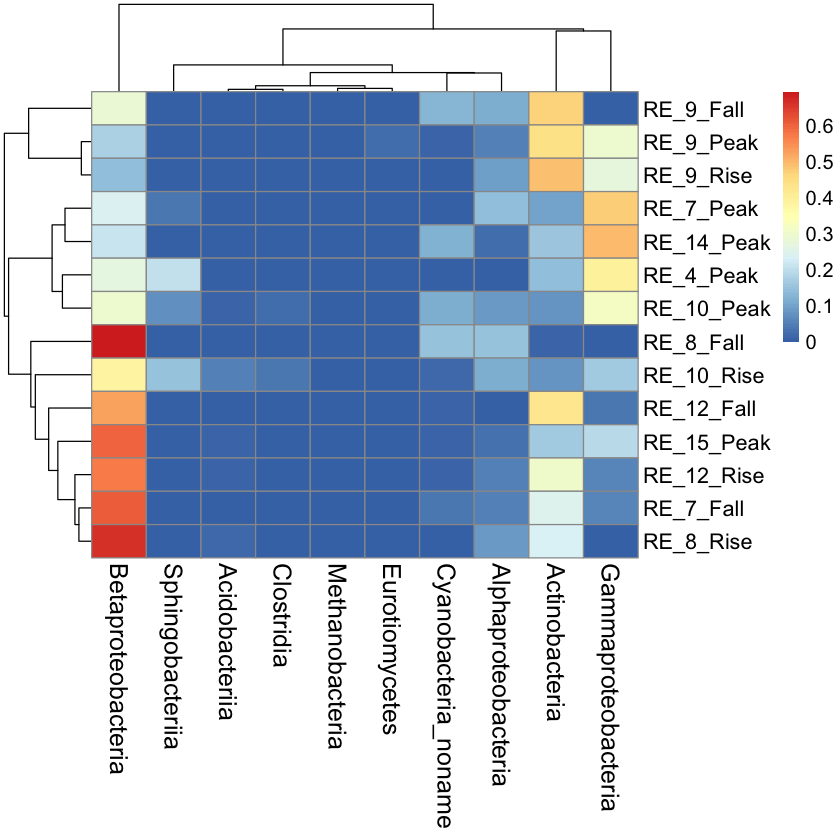

In [61]:
#plot heatmap
pheatmap(class.dt.heat, cluster_col = T, cluster_row = T, fontsize_col=15, fontsize_row = 13, show_rownames = T, 
         fontsize = 12, clustering_distance_rows = "maximum",
         clustering_distance_cols = "maximum", clustering_method = "average")

